## Changed Model archietecter from two dense 

Test 1
global avg -> dropout ->dens(27)
image flop only horizontoal 
Network trained unstable way. Val_loss and accuraccy fluctuated.
Test 47%

Test 2
image flip horizontal vertical
global avg -> dropout ->dens(27)
Test 34%

Test 3
image flop only horizontoal 
global avg -> batchnorm ->dens(27)
end in 7 Test 51% --> 44%

Test 4
image flip horizontal vertical
global avg -> batchnorm ->dens(27)
35%?

Test 5
image flip horizontal 
global avg -> dense(512)-> dropout(0.5) ->dense(27)
test 60%

Test 6
image flip horizontal vertical
global avg -> dense(512)-> dropout(0.5) ->dense(27)
test 46%

Test 7
Full retrain based on imagenet weight
image flip horizontal 
global avg -> dense(512)-> dropout(0.5) ->dense(27)
test 80%

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

'1.14.0'

In [2]:
import pandas as pd

train_df = pd.read_pickle('./mvc_train.pkl')
test_df = pd.read_pickle('./mvc_test.pkl')

In [3]:
train_df.sample(10)

,filename,attributes
11756,category/Shirts_Tops/p8525360_s3151496_v3.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
17571,category/Shirts_Tops/p8138866_s3160275_v0.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ..."
58557,category/Shirts_Tops/p8617610_s3360549_v4.jpg,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
60421,category/Coats_Outerwear/p8662422_s3467390_v3.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
99232,category/Shirts_Tops/p7648372_s1154061_v0.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
15354,category/Coats_Outerwear/p8630706_s3392653_v0.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
38360,category/Shirts_Tops/p8555032_s3222153_v0.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
82738,category/Shirts_Tops/p8651022_s3443605_v3.jpg,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
97376,category/Shirts_Tops/p8295012_s3319530_v3.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
59042,category/Shirts_Tops/p8602731_s3325764_v2.jpg,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [4]:
label = ['BoardShorts',
'ButtonUpShirts',
'Crew',
'Denim',
'FloralPrint',
'GraphicPrint',
'Halter',
'Hood',
'HorizontalStripes',
'Insulated',
'Leggings',
'LongSleeves',
'Mesh',
'Plaid',
'Polos',
'Scoop',
'ShortSleeves',
'Sleeveless',
'SnowPants',
'Stripes',
'VerticalStripes',
'Vests',
'Vneck',
'Zipper',
'halfZip',
'quarter3Zip',
'quarterZip']

In [5]:
IMG_SIZE = 256
CROP_SIZE = 224

def train_preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image/127.5) - 1
    image = tf.image.random_crop(image, [CROP_SIZE, CROP_SIZE, 3])
    #image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    
    #image /= 255.0  # normalize to [0,1] range
    

    #encoded_png_io = io.BytesIO(encoded_png)
    #image = pil.open(encoded_png_io)
    #image = np.asarray(image)    

    return image

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [CROP_SIZE, CROP_SIZE])
    #image = tf.image.random_crop(image, [CROP_SIZE, CROP_SIZE, 3])
    image = (image/127.5) - 1
    #image /= 255.0  # normalize to [0,1] range
    

    #encoded_png_io = io.BytesIO(encoded_png)
    #image = pil.open(encoded_png_io)
    #image = np.asarray(image)    

    return image

In [6]:
def train_load_and_preprocess_image(path):
    image = tf.read_file(path)
    return train_preprocess_image(image)

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [7]:
import numpy as np
train_paths = train_df['filename'].tolist()
train_label = np.asarray(train_df['attributes'].tolist())

test_paths = test_df['filename'].tolist()
test_label = np.asarray(test_df['attributes'].tolist())

In [8]:
train_path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
test_path_ds = tf.data.Dataset.from_tensor_slices(test_paths)

train_image_ds = train_path_ds.map(train_load_and_preprocess_image)
test_image_ds = test_path_ds.map(load_and_preprocess_image)

In [9]:
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_label, tf.int32))
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_label, tf.int32))

In [10]:
train_image_label_ds = tf.data.Dataset.zip((train_image_ds, train_label_ds))
print(train_image_label_ds)
test_image_label_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))
print(test_image_label_ds)

<DatasetV1Adapter shapes: ((224, 224, 3), (27,)), types: (tf.float32, tf.int32)>
<DatasetV1Adapter shapes: ((224, 224, 3), (27,)), types: (tf.float32, tf.int32)>


In [11]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.

train_image_label_ds = train_image_label_ds.shuffle(buffer_size=512).repeat()
train_image_label_ds = train_image_label_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
train_image_label_ds

<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?, 27)), types: (tf.float32, tf.int32)>

In [12]:
test_image_label_ds = test_image_label_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_image_label_ds

<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?, 27)), types: (tf.float32, tf.int32)>

In [13]:
for image_batch, label_batch in train_image_label_ds:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 27)


In [ ]:
class MVCMobilenetV2(tf.keras.Model):
    
    def __init__(self, img_shape, num_attributes):
        super(MVCMobilenetV2, self).__init__()
        self.img_shape = img_shape
        self.num_attributes = num_attributes
        
        self.base_model = tf.keras.applications.MobileNetV2(input_shape=self.img_shape, include_top=False, weights='imagenet')
        

In [14]:
IMG_SHAPE = (CROP_SIZE, CROP_SIZE, 3)


#base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape=IMG_SHAPE,
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.nasnet.NASNetMobile(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.densenet.DenseNet201(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.nasnet.NASNetLarge(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
#base_model = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [15]:
base_model.output_shape

(None, 7, 7, 1280)

OSME implementation

https://github.com/xcnkx/fine_grained_classification/blob/master/model_resnet50_with_OSME.py

In [16]:
def osme_block(in_block, ch, ratio=16):
    z = tf.keras.layers.GlobalAveragePooling2D()(in_block)
    x = tf.keras.layers.Dense(ch//ratio, activation='relu')(z)
    x = tf.keras.layers.Dense(ch, activation='sigmoid')(x)
    return tf.keras.layers.Multiply()([in_block, x])

In [17]:
s_1 = osme_block(base_model.output, base_model.output_shape[3])
s_2 = osme_block(base_model.output, base_model.output_shape[3])


In [18]:
fc1 = tf.keras.layers.Flatten()(s_1)
fc2 = tf.keras.layers.Flatten()(s_2)

In [19]:
fc1 = tf.keras.layers.Dense(1024)(fc1)
fc2 = tf.keras.layers.Dense(1024)(fc2)

In [20]:
fc = tf.keras.layers.add([fc1,fc2]) 
fc

<tf.Tensor 'add/Identity:0' shape=(?, 1024) dtype=float32>

In [21]:
prediction = tf.keras.layers.Dense(27)(fc)

In [22]:
model = tf.keras.Model(inputs=base_model.input, outputs=prediction)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [25]:
model.load_weights('./mobilev2_osme/weights')

In [26]:
nb_train_samples = len(train_paths) 
nb_val_samples = len(test_paths) 

steps_per_epoch = nb_train_samples // BATCH_SIZE
validation_steps=nb_val_samples//BATCH_SIZE
nb_val_samples

27348

In [27]:
def weighted_loss(target, prediction):
    batch = tf.shape(target)[0]
    
    #print(batch)
    target = tf.cast(target, tf.float32)
    weight = 1-tf.divide(tf.reduce_sum(target,0, keepdims=True),tf.cast(batch, tf.float32))
    #print(weight)
    #print(loss)
    return tf.nn.weighted_cross_entropy_with_logits(labels=target, logits=prediction, pos_weight=weight)
    
    #return tf.nn.weighted_cross_entropy_with_logits(targets=tf.cast(y, tf.float32), logits=y_, pos_weight=tf.cast(weight, tf.float32))

when val is very slow refer this [page](https://github.com/keras-team/keras/issues/6101)

In [28]:
#parallel_model = multi_gpu_model(model, gpus=2)
callbacks = [
    # Interrupt training if `val_loss` stops improving for over 2 epochs
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint(filepath='./mobilev2_osme/finetune_aug.top.h5', save_best_only=True),
    # Write TensorBoard logs to `./logs` directory
    tf.keras.callbacks.TensorBoard(log_dir='./mobilev2_osme/logs')
]

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss=weighted_loss, optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
#model.load_weights('./mobilev2_2019072004/weights')


In [ ]:
history = model.fit(train_image_label_ds, steps_per_epoch=steps_per_epoch, epochs=20, validation_data=test_image_label_ds, validation_steps=validation_steps, \
          workers=4, use_multiprocessing=True , callbacks=callbacks)

Epoch 1/20
3418/3418 [==============================] - 2416s 707ms/step - loss: 0.0530 - binary_accuracy: 0.9786 - val_loss: 0.0756 - val_binary_accuracy: 0.9703
Epoch 2/20
3418/3418 [==============================] - 2368s 693ms/step - loss: 0.0516 - binary_accuracy: 0.9791 - val_loss: 0.0681 - val_binary_accuracy: 0.9731
Epoch 3/20
3418/3418 [==============================] - 2358s 690ms/step - loss: 0.0502 - binary_accuracy: 0.9796 - val_loss: 0.0639 - val_binary_accuracy: 0.9740
Epoch 4/20
3418/3418 [==============================] - 2361s 691ms/step - loss: 0.0488 - binary_accuracy: 0.9801 - val_loss: 0.0634 - val_binary_accuracy: 0.9747
Epoch 5/20
3418/3418 [==============================] - 2360s 690ms/step - loss: 0.0476 - binary_accuracy: 0.9805 - val_loss: 0.0628 - val_binary_accuracy: 0.9751
Epoch 6/20
3418/3418 [==============================] - 2352s 688ms/step - loss: 0.0465 - binary_accuracy: 0.9809 - val_loss: 0.0631 - val_binary_accuracy: 0.9744
Epoch 7/20
3418/3418 [

In [35]:
model.save('./mobilev2_osme/finetune_aug.h5')

In [36]:
model.save_weights('./mobilev2_osme/weights')

In [37]:
path='./rename/p8604244_s3328909_v0.jpg'
image = tf.read_file(path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, [224,224])
image = image/127.5 - 1 # normalize to [0,1] range
pred = model.predict(image[np.newaxis, ...])
indexes = np.where(pred[0,:]> 0.5)
attr=pd.Series(label)
attr.iloc[indexes]

17    Sleeveless
dtype: object

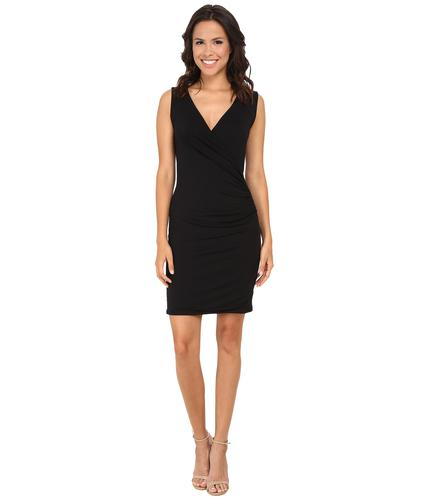

In [38]:
from IPython.display import Image
Image(path)

In [39]:
import matplotlib.pyplot as plt


acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

NameError: name 'history' is not defined